# Primary model experiments

This notebook intends to test the models specified in the file `preliminary_model.pdf` to estimate prevalence. 

In [26]:
import numpy as np
import pandas as pd
import pystan as ps
from scipy.special import logit, expit

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle

sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Perfect tests

In [3]:
compiled = False

In [12]:
if compiled: 
    sm = pickle.load(open('pickles/perfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/perfect_test.stan')
    with open('pickles/model1.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00a8c0834a37af1dc353c25afbc75fe4 NOW.


### Data

First we describe data created artificially. 

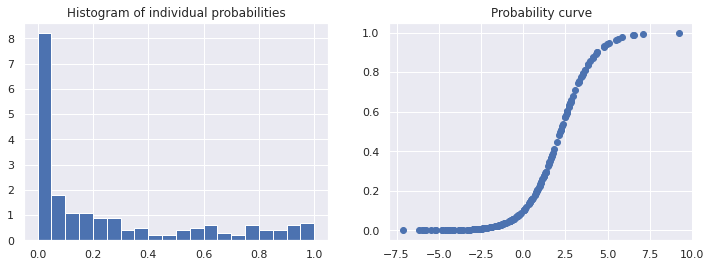

In [47]:
n_samples    = 200
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors+1), 
                           cov = np.eye(n_predictors+1),
                           size = n_samples) 

beta = np.array([0.5, 0.1, 2.5, -1.0, 1.2, 0.3]).reshape(-1,1)
prevalence = 0.1

theta = expit(logit(prevalence) + x@beta)

T = ro.binomial(n = 1, p = theta)

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].hist(theta, density = True, bins = 20)
ax[1].scatter(x@beta, theta)

ax[0].set_title('Histogram of individual probabilities')
ax[1].set_title('Probability curve')

plt.show()

In [59]:
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x,
}

T.mean()

0.215

Now we describe the necessary pieces to the model. 

In [60]:
Sigma   = np.eye(6)
mu      = np.zeros(6)
alpha_p = 1
beta_p  = 3

data.update({
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p
})

And we apply it to the sampling.

In [65]:
fit = sm.sampling(data=data)

In [66]:
print(fit)

Inference for Stan model: anon_model_00a8c0834a37af1dc353c25afbc75fe4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
effects[1]         -0.02  3.3e-3   0.25  -0.51  -0.19   -0.01   0.15   0.48   5746    1.0
effects[2]         -0.24  3.3e-3   0.23  -0.69  -0.39   -0.24  -0.07   0.21   4957    1.0
effects[3]          2.51  7.4e-3   0.38    1.8   2.24     2.5   2.76    3.3   2714    1.0
effects[4]         -0.88  4.1e-3   0.26   -1.4  -1.04   -0.87   -0.7  -0.39   3914    1.0
effects[5]           1.4  5.5e-3    0.3   0.83   1.19    1.39   1.59   1.99   2929    1.0
effects[6]          0.43  3.8e-3   0.26  -0.06   0.26    0.43   0.61   0.94   4666    1.0
prev                0.06  4.5e-4   0.02   0.03   0.05    0.06   0.08   0.11   2412    1.0
effects_prior[1] -6.4e-4    0.02    1.0  -1.91   -0.7   -0.01   0.69   2.03   3991    1.0
e

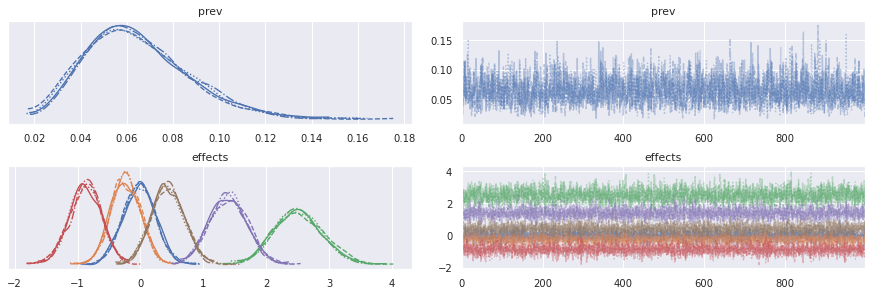

In [70]:
az.plot_trace(fit, var_names=('prev', 'effects'))
plt.show()

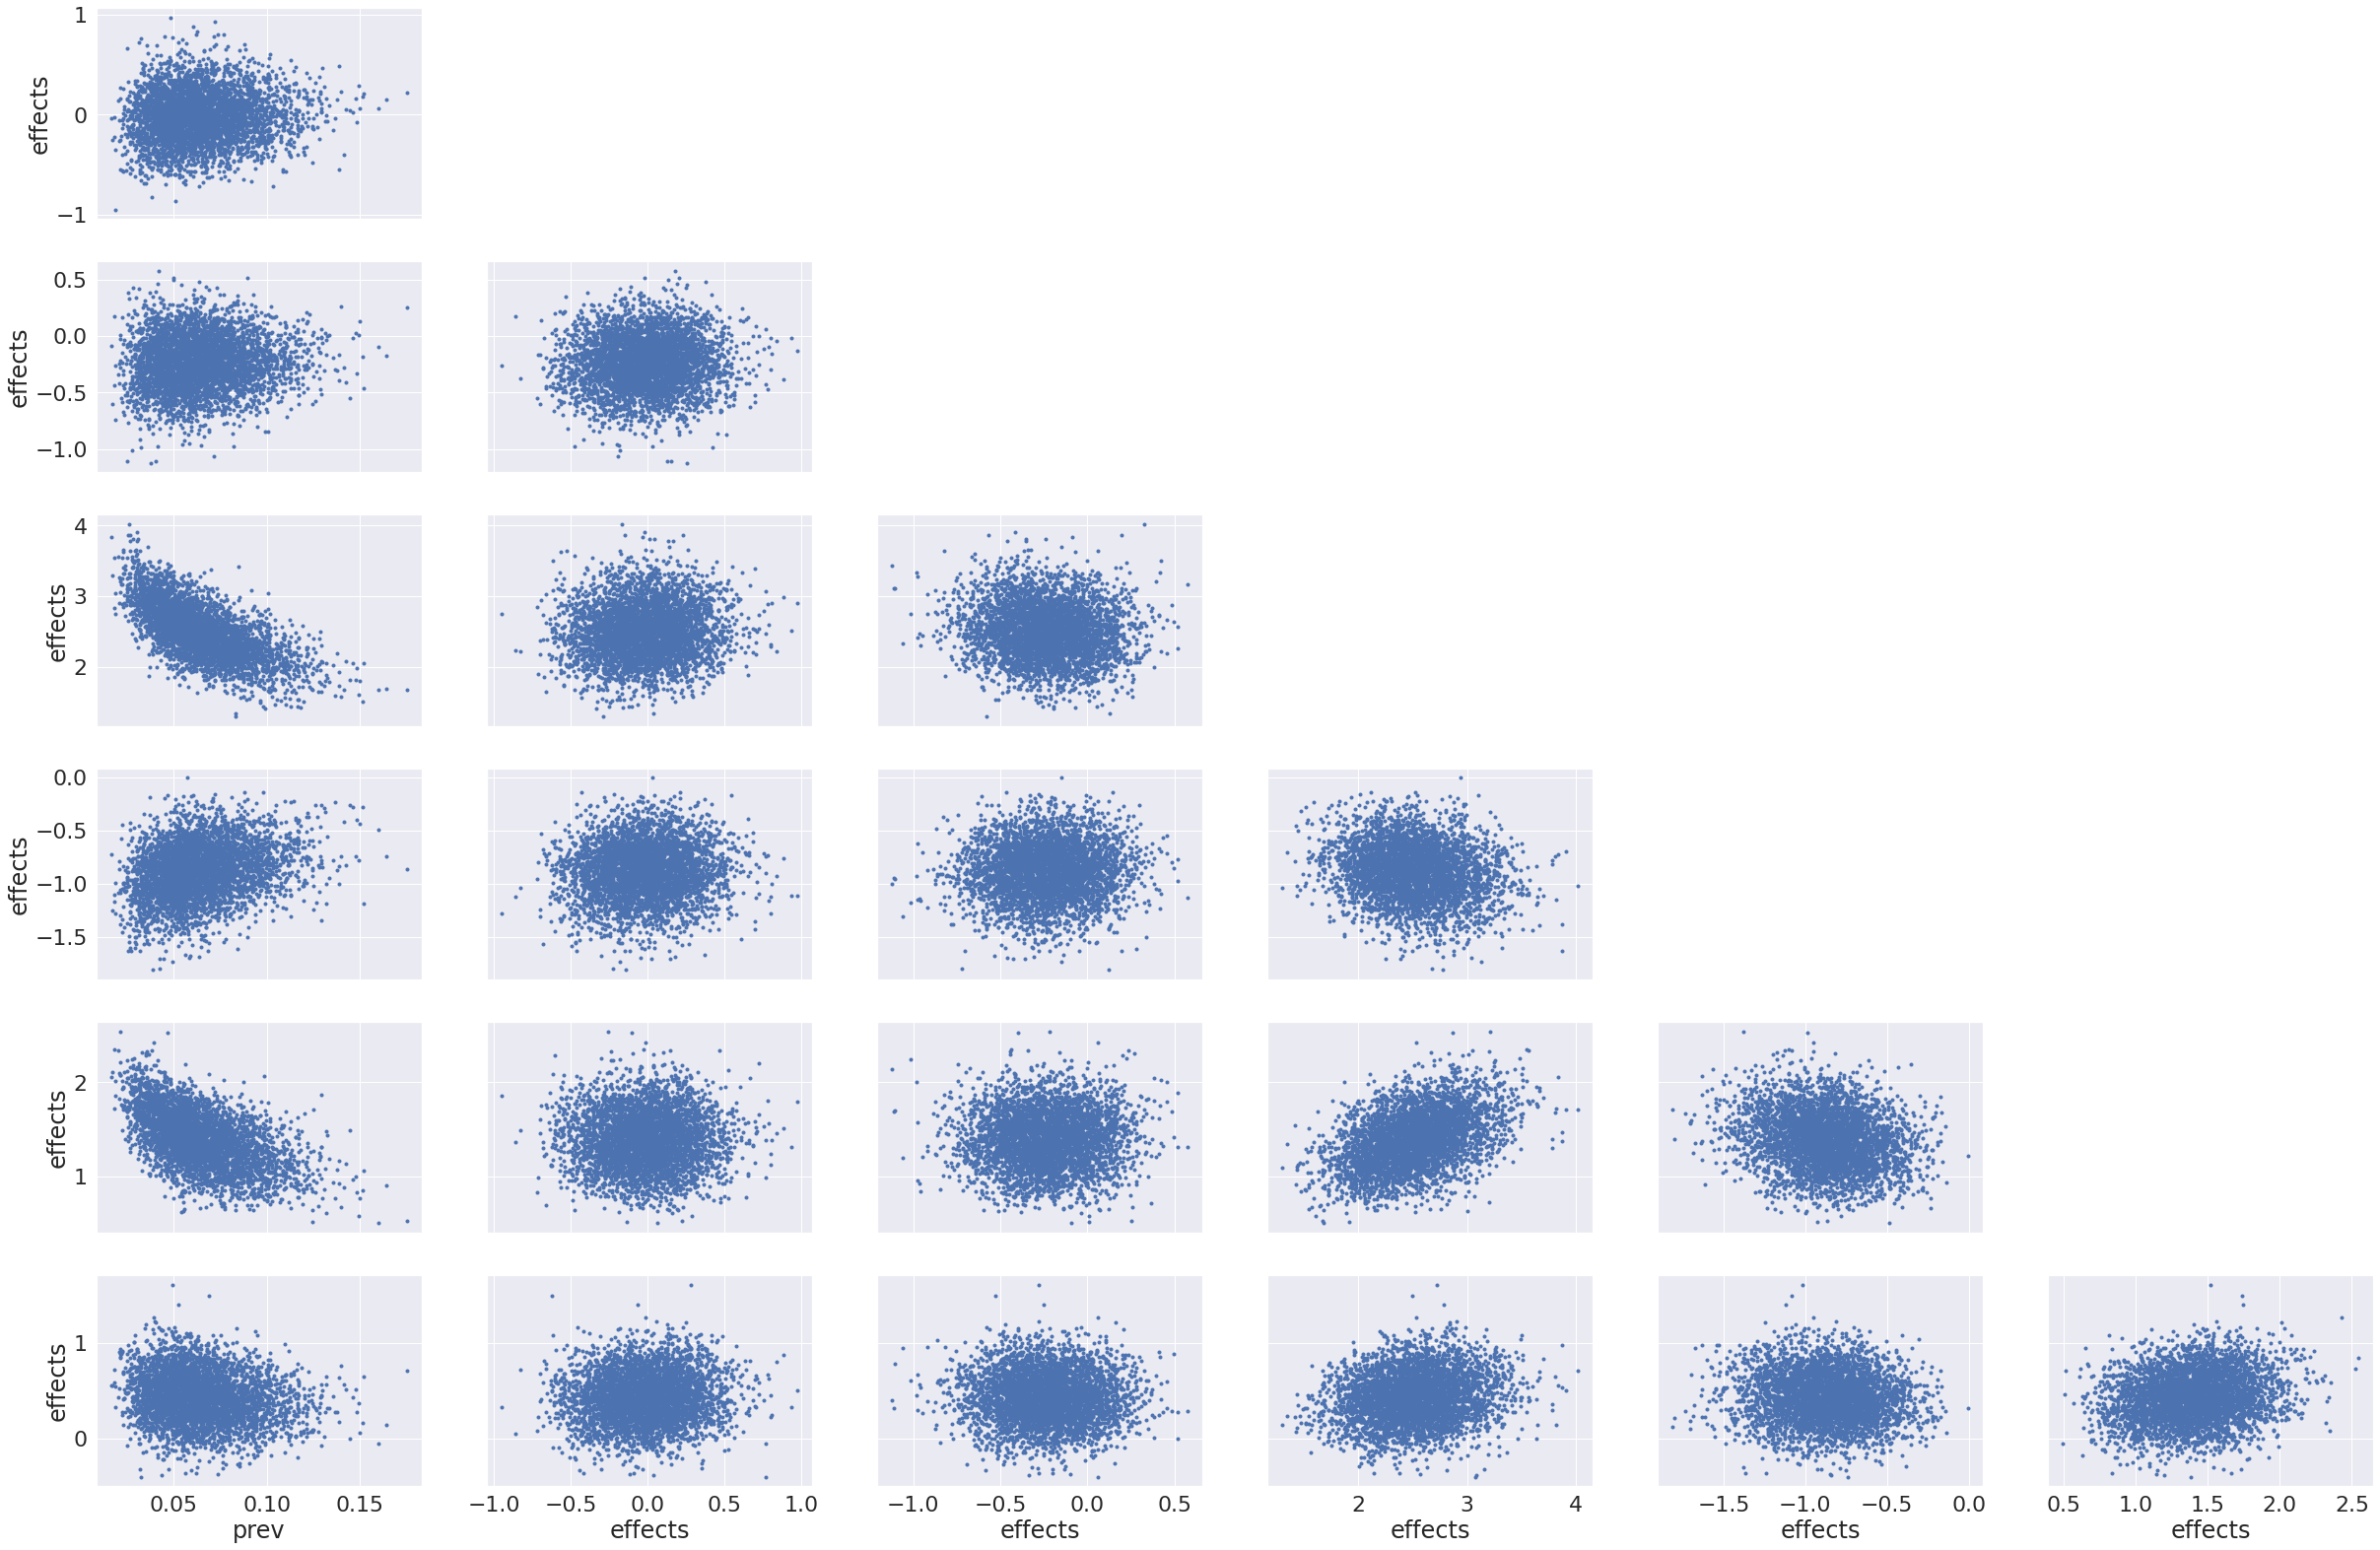

In [72]:
az.plot_pair(
    fit, var_names=["prev", "effects"], textsize=22
)
plt.show()